In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!ls

Untitled.ipynb
ecoli_genome.fasta
rnap_convet-Copy1.ipynb
rnap_convet.ipynb
rnap_negative_examples.txt
rnap_negative_scanned_over_yeast_genome.csv
rnap_negative_scanned_over_yeast_genome1.csv
rnap_scanned_over_yeast_genome1.csv
rnap_tau_final_all.41.matrix.txt


In [3]:
input_data_raw =  pd.read_csv('rnap_scanned_over_yeast_genome1.csv')
#input_data_raw = input_data_raw.loc[0:3999,]
sequences = input_data_raw['seq'].tolist()
#np.shape(sequences)

In [4]:
input_data_raw.head()

,Unnamed: 0,val,val_norm,seq,left,right,ori,contig,Unnamed: 8
0,0,23.9083,0.000251,CTATTACCTGCCCACGGTAAAGGCGTTCTGGTTGCCCTACG,3695629,3695669,+,MG1655.fa,0.000251
1,1,23.5831,0.000248,TTTCTGCCCGCGGCCTGGCAATTGATACCGCCTTGCCATCG,1109059,1109099,+,MG1655.fa,0.000248
2,2,23.4205,0.000246,TTTTTACACGCCTTGCGTAAAGCGGCACGGCGCGGGGTGCG,822216,822256,-,MG1655.fa,0.000246
3,3,23.4098,0.000246,TTGCTGCCTGGCCGATGGTCTATGCCGCTGCGTTCTCCGGC,772478,772518,+,MG1655.fa,0.000246
4,4,23.3640,0.000245,CTTTTACACGCAAAATGCCGTCACGTTCACGGGTCTGGGCT,2748531,2748571,+,MG1655.fa,0.000245


In [5]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# The LabelEncoder encodes a sequence of bases as a sequence of integers.
integer_encoder = LabelEncoder()  
# The OneHotEncoder converts an array of integers to a sparse matrix where 
# each row corresponds to one possible value of each feature.
one_hot_encoder = OneHotEncoder(n_values=4)   
input_features = []

for sequence in sequences:
  integer_encoded = integer_encoder.fit_transform(list(sequence))
  integer_encoded = np.array(integer_encoded).reshape(-1, 1)
  one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
  input_features.append(one_hot_encoded.toarray())

#np.set_printoptions(threshold=np.nan)
input_features = np.stack(input_features)


In [6]:
print("Example sequence\n-----------------------")
print(sequences[0])

Example sequence
-----------------------
CTATTACCTGCCCACGGTAAAGGCGTTCTGGTTGCCCTACG


In [7]:
np.shape(input_features)

(8000, 41, 4)

In [8]:
labels = input_data_raw['val_norm'].tolist()
#np.shape(labels)
input_labels = labels
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
#input_labels = scale.fit_transform(np.array(input_labels).reshape(-1,1))
input_labels = scale.fit_transform(np.array(input_labels).reshape(-1,1))

In [9]:
#input_labels[3995:4005]

In [10]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(
    input_features, input_labels, test_size=0.25, random_state=40)

def rmse(y_true, y_pred):
    from keras import backend
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

# coefficient of determination (R^2) for regression
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

In [11]:
from keras import optimizers
from keras.models import Sequential
from keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Dropout

/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [12]:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=12, 
                 input_shape=(train_features.shape[1], 4)))
model.add(MaxPooling1D(pool_size=4))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='linear'))


#sgd = optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(loss='mean_squared_error',optimizer='adam', 
              metrics=['mean_squared_error',r_square])

#model.compile(loss='mean_squared_error',optimizer='sgd', 
#              metrics=['accuracy'])

model.summary()

history = model.fit(train_features, train_labels, 
                    epochs=50, verbose=0, validation_split=0.25)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 30, 32)            1568      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 32)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 224)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                3600      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 5,185
Trainable params: 5,185
Non-trainable params: 0
_________________________________________________________________


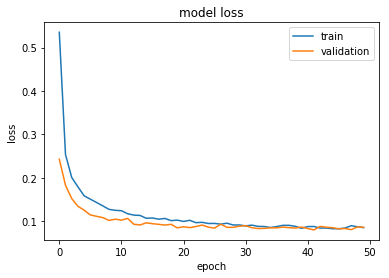

In [13]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [14]:
model.evaluate(test_features,test_labels)

2000/2000 [==============================] - 0s 36us/step


[0.09466475144028663, 0.09466475144028663, 0.9027835583686828]

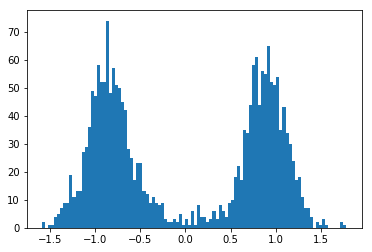

In [15]:
plt.hist(model.predict(test_features),bins=100)
plt.show()

In [16]:
1-model.evaluate(test_features,test_labels)[1]

2000/2000 [==============================] - 0s 45us/step


0.9053352485597134

In [17]:
#test_sequence = ''
#for base_array in test_features[0]:
#    if(base_array[0]==1):
#        test_sequence+='A'
#    elif(base_array[1]==1):
#        test_sequence+='C'
#    elif(base_array[2]==1):
#        test_sequence+='G'
#    elif(base_array[3]==1):
#        test_sequence+='T'
    
#test_sequence    

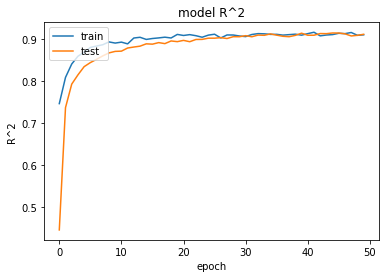

In [18]:
# plot training curve for R^2 (beware of scale, starts very low negative)
plt.plot(history.history['val_r_square'])
plt.plot(history.history['r_square'])
plt.title('model R^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

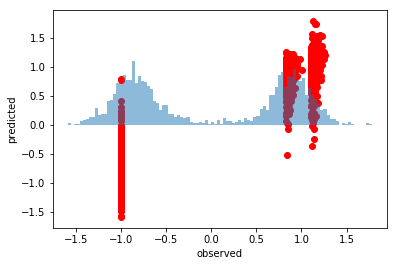

In [19]:
y_pred = model.predict(test_features)


plt.scatter(test_labels, y_pred, color='red', label= 'data')
plt.hist(model.predict(test_features),bins=100,density=True,alpha=0.5)
#plt.plot(y_pred, y_fit, color='red', linewidth=2, label = 'Linear regression\n'+reg_label) 
#plt.title('Linear Regression')
#plt.legend()
plt.xlabel('observed')
plt.ylabel('predicted')
plt.show()